# 🫁 Lung Segmentation Mask Pre-computation & Tuning

**Purpose:** Pre-compute lung segmentation masks for the entire NIH Chest X-ray dataset and save them to disk for reuse across all option notebooks.

**Features:**
- 🔧 Tunable segmentation thresholds (binary threshold, morphology kernel, lung area ratio, patch threshold)
- 📊 Multi-perspective visualization (overlay, contour, side-by-side, patch-grid, heatmap)
- 💾 Save pixel-level masks (`.npy`) and patch-level masks to disk
- ⚡ Load pre-computed masks in any option notebook instead of computing on-the-fly

In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================

import warnings
warnings.filterwarnings('ignore')

import os, sys, glob, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import cv2
from collections import OrderedDict

try:
    import kagglehub
except ImportError:
    pass

IN_KAGGLE = os.path.exists('/kaggle/input')
IN_COLAB = 'google.colab' in sys.modules

print("✅ All libraries imported")

✅ All libraries imported


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

if IN_KAGGLE:
    BASE_PATH = Path('/kaggle/input/nih-chest-xrays')
elif IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/nih-chest-xrays')
else:
    path = kagglehub.dataset_download("nih-chest-xrays/data")
    BASE_PATH = Path(path)

print(f"📂 Base path: {BASE_PATH}")

# Load metadata
csv_path = BASE_PATH / 'Data_Entry_2017.csv'
df = pd.read_csv(csv_path)

# Find image paths
image_dirs = list(BASE_PATH.glob('images_*/images'))
if not image_dirs:
    image_dirs = [BASE_PATH / 'images']

image_map = {}
for d in image_dirs:
    for f in d.iterdir():
        if f.suffix == '.png':
            image_map[f.name] = str(f)

df['Image Path'] = df['Image Index'].map(image_map)
df = df.dropna(subset=['Image Path']).reset_index(drop=True)

print(f"✅ Loaded {len(df):,} images")
print(f"📂 Image directories: {len(image_dirs)}")

📂 Base path: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
✅ Loaded 112,120 images
📂 Image directories: 12


In [3]:
# ============================================
# ⚙️ Step 3: Segmentation Configuration
# ============================================

class SegConfig:
    """
    ╔══════════════════════════════════════════════════════════════╗
    ║  🔧 TUNE THESE PARAMETERS to get the best segmentation    ║
    ╚══════════════════════════════════════════════════════════════╝
    """
    img_size = 224                  # Resize target (must match your model input)

    # ── Thresholding ──
    use_otsu = True                 # True = auto Otsu, False = fixed threshold
    fixed_threshold = 127           # Used only when use_otsu=False

    # ── Morphology ──
    morph_kernel_size = 7           # Kernel size for close/open operations (odd number)
    morph_iterations = 1            # Number of morphological iterations

    # ── Lung selection ──
    min_lung_area_ratio = 0.01      # Minimum area ratio to consider a region as lung
    max_components = 2              # Keep top-N connected components (2 = left + right lung)
    central_margin = 0.15          # Ignore components outside central (1-2*margin) region

    # ── Contrast-adaptive thresholding ──
    adaptive_contrast = True           # Adjust threshold based on image contrast
    contrast_reference_std = 50.0      # Typical chest X-ray stddev (~50)
    contrast_scale = 0.5               # How aggressively to adjust (0=off, 1=strong)

    # ── CLAHE preprocessing ──
    use_clahe = True                   # Apply CLAHE to normalize contrast before thresholding
    clahe_clip_limit = 2.0             # CLAHE contrast clip limit (higher = more contrast)
    clahe_grid_size = 8                # CLAHE tile grid size

    # ── Edge smoothing ──
    gaussian_blur_size = 11         # Gaussian blur kernel for mask boundary smoothing (odd number)
    mask_binarize_threshold = 0.3   # After blur: pixels above this → lung

    # ── Patch-level ──
    patch_size = 16                 # ViT patch size
    patch_lung_threshold = 0.3     # Fraction of lung pixels for a patch to count as "lung"

    # ── Storage ──
    save_pixel_masks = True         # Save full 224×224 pixel masks
    save_patch_masks = True         # Save patch-level masks (14×14 = 196 values)
    mask_dtype = np.uint8           # uint8 saves space (0 or 255); float32 for soft masks

cfg = SegConfig()

# Output directory
if IN_KAGGLE:
    MASK_OUTPUT_DIR = '/kaggle/working/lung_masks'
elif IN_COLAB:
    MASK_OUTPUT_DIR = '/content/drive/MyDrive/lung_masks'
else:
    MASK_OUTPUT_DIR = './lung_masks'

PIXEL_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'pixel_masks')
PATCH_MASK_DIR = os.path.join(MASK_OUTPUT_DIR, 'patch_masks')

os.makedirs(PIXEL_MASK_DIR, exist_ok=True)
os.makedirs(PATCH_MASK_DIR, exist_ok=True)

print("✅ Segmentation configuration ready")
print(f"   Image size: {cfg.img_size}")
print(f"   Otsu threshold: {cfg.use_otsu}")
print(f"   Morph kernel: {cfg.morph_kernel_size}")
print(f"   Patch size: {cfg.patch_size}")
print(f"   Output dir: {MASK_OUTPUT_DIR}")

✅ Segmentation configuration ready
   Image size: 224
   Otsu threshold: True
   Morph kernel: 7
   Patch size: 16
   Output dir: ./lung_masks


In [4]:
# ============================================
# 🫁 Step 4: Configurable Lung Segmentation Function
# ============================================

def segment_lungs(image, config=None):
    """
    Rule-based lung segmentation with tunable parameters.

    Args:
        image: numpy array (H, W) float32 [0,1] or uint8 [0,255]
        config: SegConfig instance (uses global cfg if None)

    Returns:
        mask: binary mask (H, W) float32, 1 = lung region
    """
    if config is None:
        config = cfg

    # Ensure uint8
    if image.dtype != np.uint8:
        img = (image * 255).astype(np.uint8)
    else:
        img = image.copy()

    # 0. CLAHE — normalize local contrast (helps dark/low-contrast images)
    if config.use_clahe:
        clahe = cv2.createCLAHE(
            clipLimit=config.clahe_clip_limit,
            tileGridSize=(config.clahe_grid_size, config.clahe_grid_size)
        )
        img = clahe.apply(img)

    # 1. Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # 2. Contrast-adaptive thresholding
    #    High contrast (lots of dark+white) → strict, select only very dark
    #    Low contrast (uniformly grey)      → lenient, include greyish regions
    if config.use_otsu:
        otsu_val, _ = cv2.threshold(blurred, 0, 255,
                                     cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if config.adaptive_contrast:
            std_val = np.std(blurred)
            # High std → lower threshold (stricter); Low std → raise (lenient)
            shift = (std_val - config.contrast_reference_std) * config.contrast_scale
            adjusted = int(np.clip(otsu_val - shift, 40, 220))
            _, thresh = cv2.threshold(blurred, adjusted, 255,
                                      cv2.THRESH_BINARY_INV)
        else:
            _, thresh = cv2.threshold(blurred, 0, 255,
                                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, thresh = cv2.threshold(blurred, config.fixed_threshold, 255,
                                  cv2.THRESH_BINARY_INV)

    # 3. Connected components — keep largest regions
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    if num_labels <= 1:
        return np.ones_like(img, dtype=np.float32)

    # Filter by minimum area
    total_area = img.shape[0] * img.shape[1]
    min_area = total_area * config.min_lung_area_ratio
    areas = stats[1:, cv2.CC_STAT_AREA]  # skip background
    valid_idx = np.where(areas >= min_area)[0]

    if len(valid_idx) == 0:
        return np.ones_like(img, dtype=np.float32)

    # Filter: keep only components that intersect the central region
    # (lungs are always central; this rejects border/edge artifacts)
    if config.central_margin > 0:
        H, W = img.shape
        mh, mw = int(H * config.central_margin), int(W * config.central_margin)
        central_zone = np.zeros_like(img, dtype=bool)
        central_zone[mh:H-mh, mw:W-mw] = True
        central_valid = [idx for idx in valid_idx
                         if np.any((labels == (idx + 1)) & central_zone)]
        if len(central_valid) > 0:  # fallback to original if none pass
            valid_idx = np.array(central_valid)

    # Sort by area, keep top-N
    sorted_idx = valid_idx[np.argsort(areas[valid_idx])[::-1]]
    keep = sorted_idx[:config.max_components]

    mask = np.zeros_like(img, dtype=np.uint8)
    for k in keep:
        mask[labels == (k + 1)] = 255  # +1 because we skipped background

    # 4. Morphological cleaning
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (config.morph_kernel_size, config.morph_kernel_size)
    )
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=config.morph_iterations)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=config.morph_iterations)

    # 5. Edge smoothing
    if config.gaussian_blur_size > 0:
        mask = cv2.GaussianBlur(mask, (config.gaussian_blur_size, config.gaussian_blur_size), 0)

    # 6. Binarize
    mask = (mask / 255.0).astype(np.float32)
    mask = (mask > config.mask_binarize_threshold).astype(np.float32)

    return mask


def lung_mask_to_patch_mask(lung_mask, patch_size=16, img_size=224, threshold=0.3):
    """
    Convert pixel-level lung mask to patch-level mask (vectorized).
    A patch is 'lung' if > threshold fraction of its pixels are lung.
    """
    h_patches = img_size // patch_size
    w_patches = img_size // patch_size
    reshaped = lung_mask.reshape(h_patches, patch_size, w_patches, patch_size)
    patch_means = reshaped.transpose(0, 2, 1, 3).reshape(h_patches * w_patches, -1).mean(axis=1)
    return (patch_means > threshold).astype(np.float32)


def load_and_preprocess(img_path, img_size=224):
    """Load image with cv2 and resize."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    return img.astype(np.float32) / 255.0

print("✅ Segmentation functions defined")

✅ Segmentation functions defined


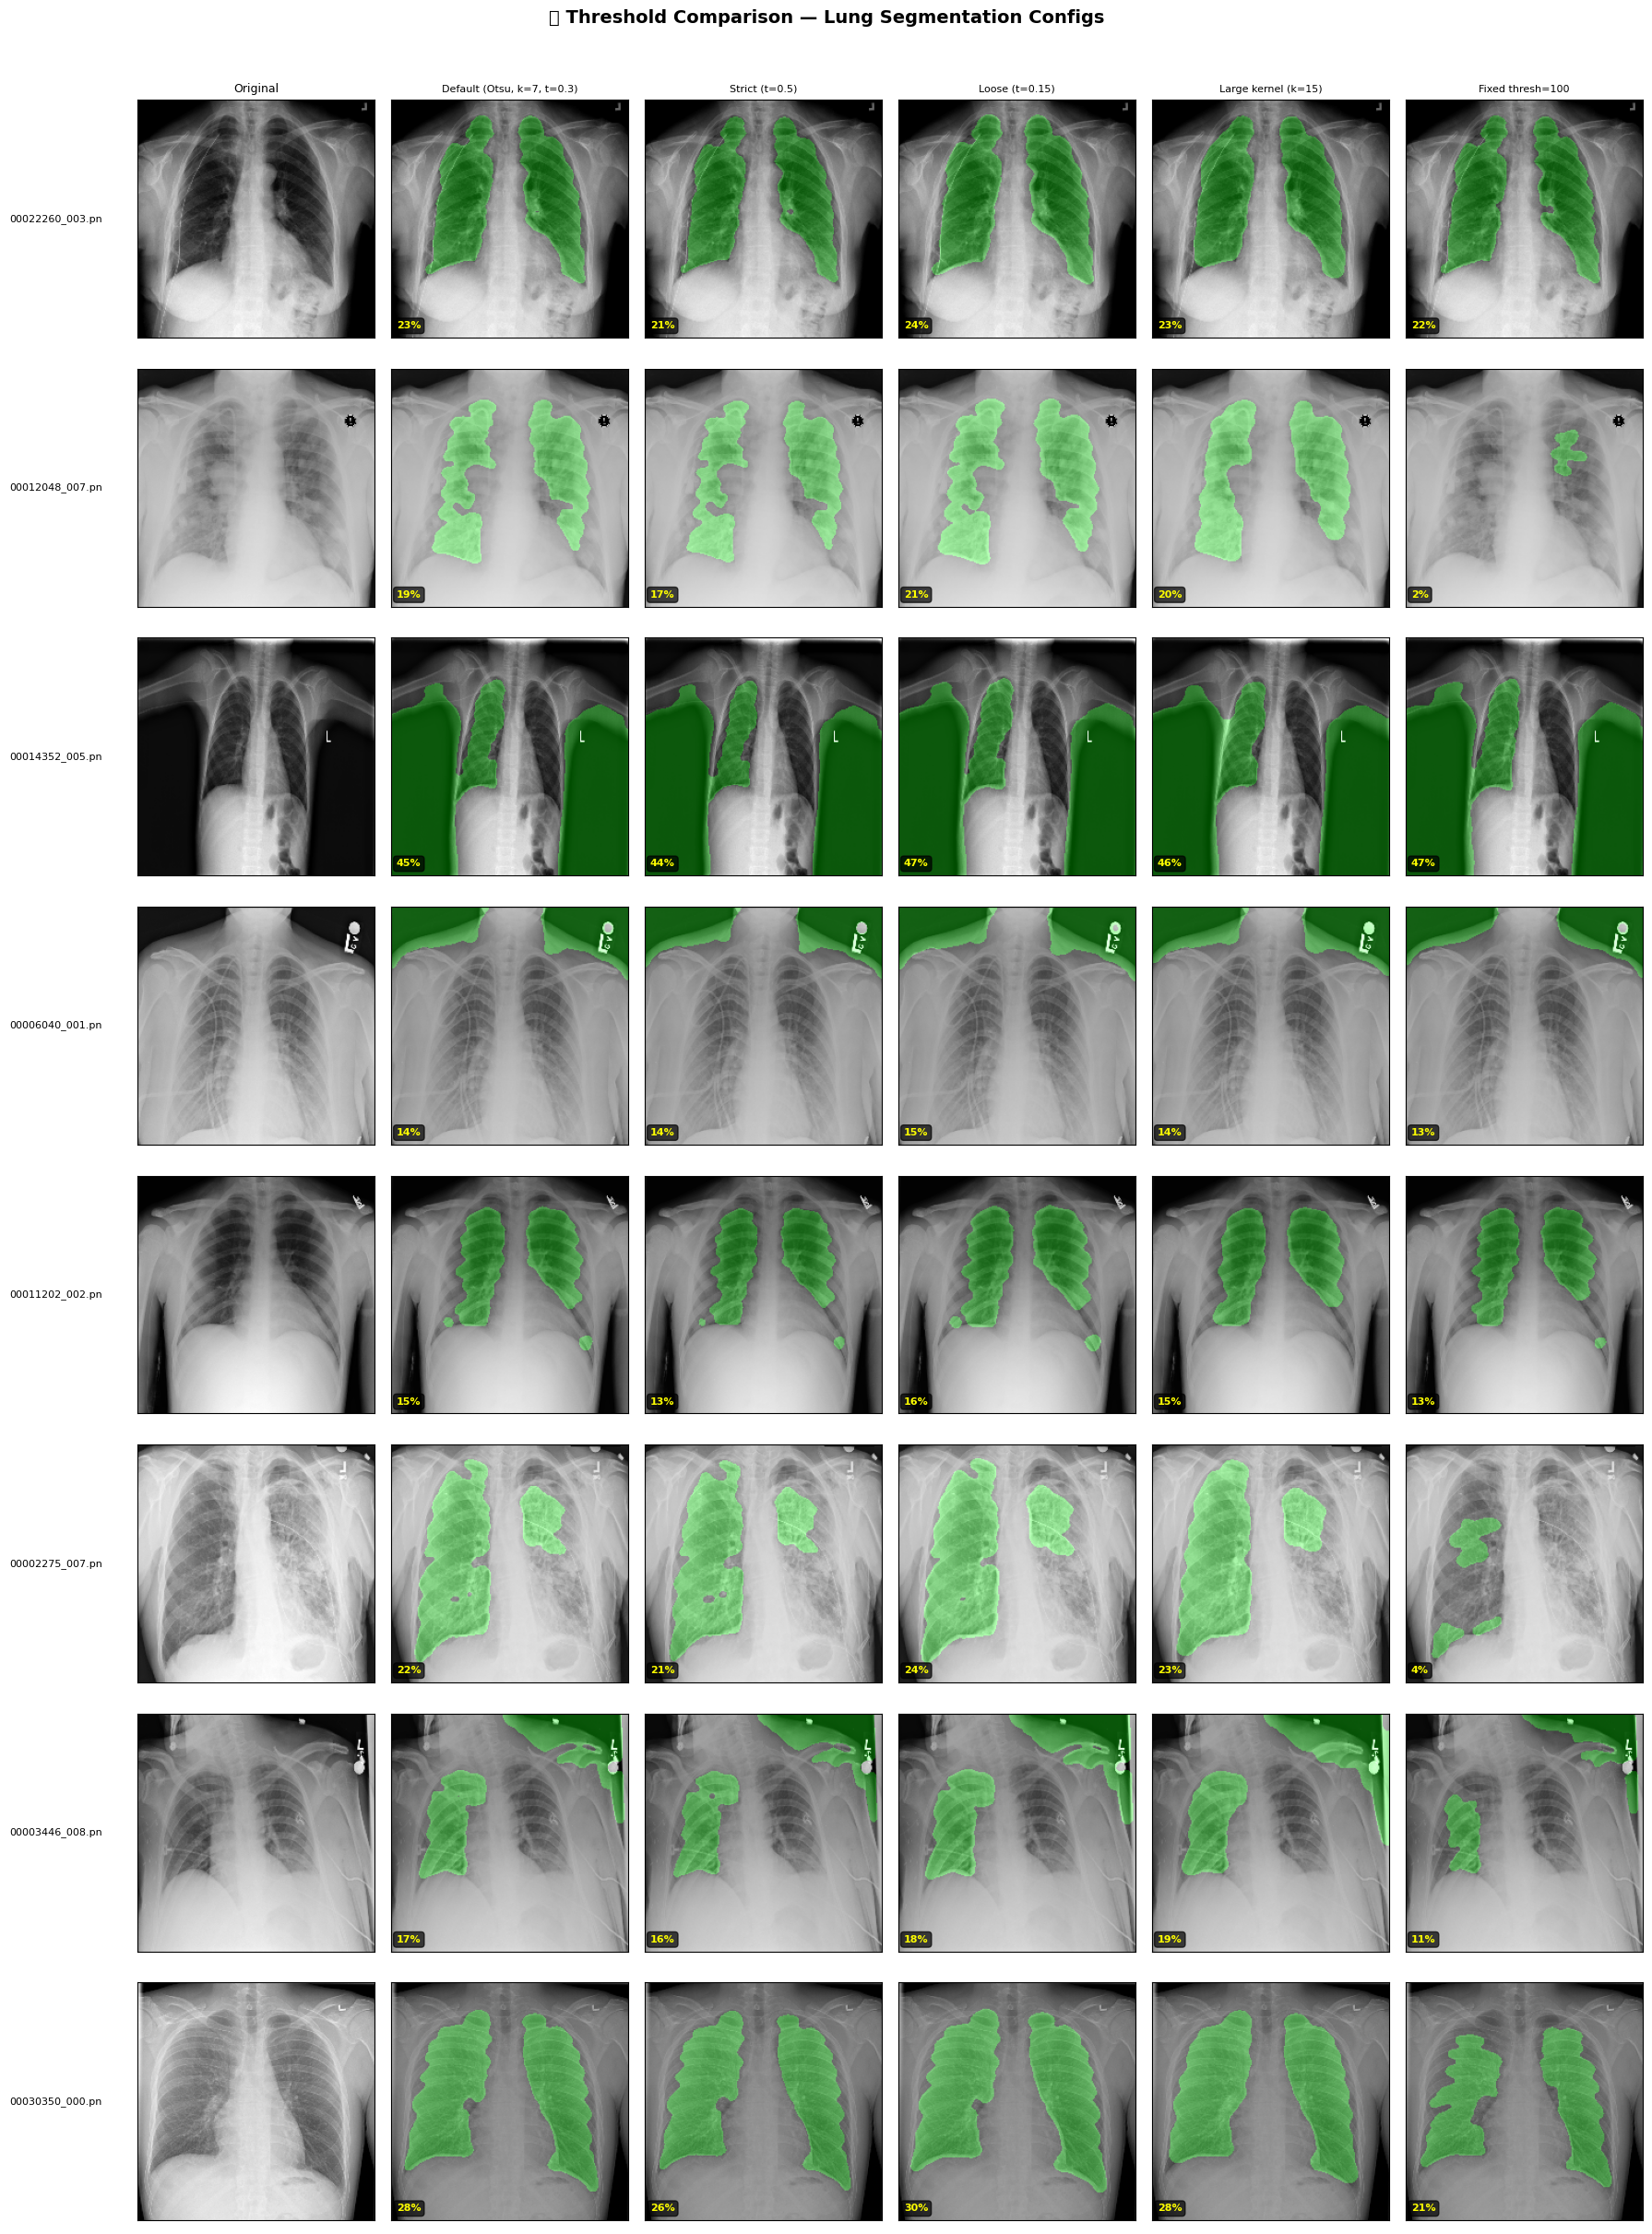


📊 Coverage statistics per config:
------------------------------------------------------------
  Default (Otsu, k=7, t=0.3)    : mean= 22.9%, min= 14.3%, max= 45.1%
  Strict (t=0.5)                : mean= 21.4%, min= 13.4%, max= 43.6%
  Loose (t=0.15)                : mean= 24.3%, min= 14.9%, max= 46.5%
  Large kernel (k=15)           : mean= 23.4%, min= 14.3%, max= 46.1%
  Fixed thresh=100              : mean= 16.5%, min=  1.6%, max= 46.8%


In [5]:
# ============================================
# 🔧 Step 5: Interactive Threshold Exploration
# ============================================
# Compare different segmentation configs side-by-side on sample images

# Sample a few images for exploration
np.random.seed(42)
sample_indices = np.random.choice(len(df), size=8, replace=False)
sample_paths = [df.iloc[i]['Image Path'] for i in sample_indices]
sample_names = [df.iloc[i]['Image Index'] for i in sample_indices]

# ── Define configs to compare ──
configs_to_test = OrderedDict({
    "Default (Otsu, k=7, t=0.3)": SegConfig(),

    "Strict (t=0.5)": type('C', (), {
        **{k: v for k, v in vars(SegConfig).items() if not k.startswith('_')},
        'mask_binarize_threshold': 0.5
    })(),

    "Loose (t=0.15)": type('C', (), {
        **{k: v for k, v in vars(SegConfig).items() if not k.startswith('_')},
        'mask_binarize_threshold': 0.15
    })(),

    "Large kernel (k=15)": type('C', (), {
        **{k: v for k, v in vars(SegConfig).items() if not k.startswith('_')},
        'morph_kernel_size': 15
    })(),

    "Fixed thresh=100": type('C', (), {
        **{k: v for k, v in vars(SegConfig).items() if not k.startswith('_')},
        'use_otsu': False, 'fixed_threshold': 100
    })(),
})

n_configs = len(configs_to_test)
n_samples = len(sample_paths)

fig, axes = plt.subplots(n_samples, n_configs + 1, figsize=(3 * (n_configs + 1), 3 * n_samples))

for row, (path, name) in enumerate(zip(sample_paths, sample_names)):
    img = load_and_preprocess(path, cfg.img_size)

    # Original image
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title("Original" if row == 0 else "", fontsize=9)
    axes[row, 0].set_ylabel(name[:15], fontsize=8, rotation=0, labelpad=60, va='center')
    axes[row, 0].set_xticks([]); axes[row, 0].set_yticks([])

    # Each config
    for col, (cfg_name, cfg_obj) in enumerate(configs_to_test.items(), 1):
        mask = segment_lungs(img, config=cfg_obj)
        coverage = mask.mean() * 100

        # Overlay: green mask on grayscale
        overlay = np.stack([img, img, img], axis=-1)
        overlay[:, :, 1] = np.clip(overlay[:, :, 1] + mask * 0.3, 0, 1)

        axes[row, col].imshow(overlay)
        axes[row, col].set_title(cfg_name if row == 0 else "", fontsize=8)
        axes[row, col].text(5, 215, f"{coverage:.0f}%", color='yellow',
                           fontsize=8, fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        axes[row, col].set_xticks([]); axes[row, col].set_yticks([])

plt.suptitle("🔧 Threshold Comparison — Lung Segmentation Configs",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(MASK_OUTPUT_DIR, 'threshold_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Coverage statistics per config:")
print("-" * 60)
for cfg_name, cfg_obj in configs_to_test.items():
    coverages = []
    for path in sample_paths:
        img = load_and_preprocess(path, cfg.img_size)
        mask = segment_lungs(img, config=cfg_obj)
        coverages.append(mask.mean() * 100)
    print(f"  {cfg_name:30s}: mean={np.mean(coverages):5.1f}%, "
          f"min={np.min(coverages):5.1f}%, max={np.max(coverages):5.1f}%")

Sweeping thresholds: 100%|██████████| 200/200 [00:14<00:00, 13.79it/s]


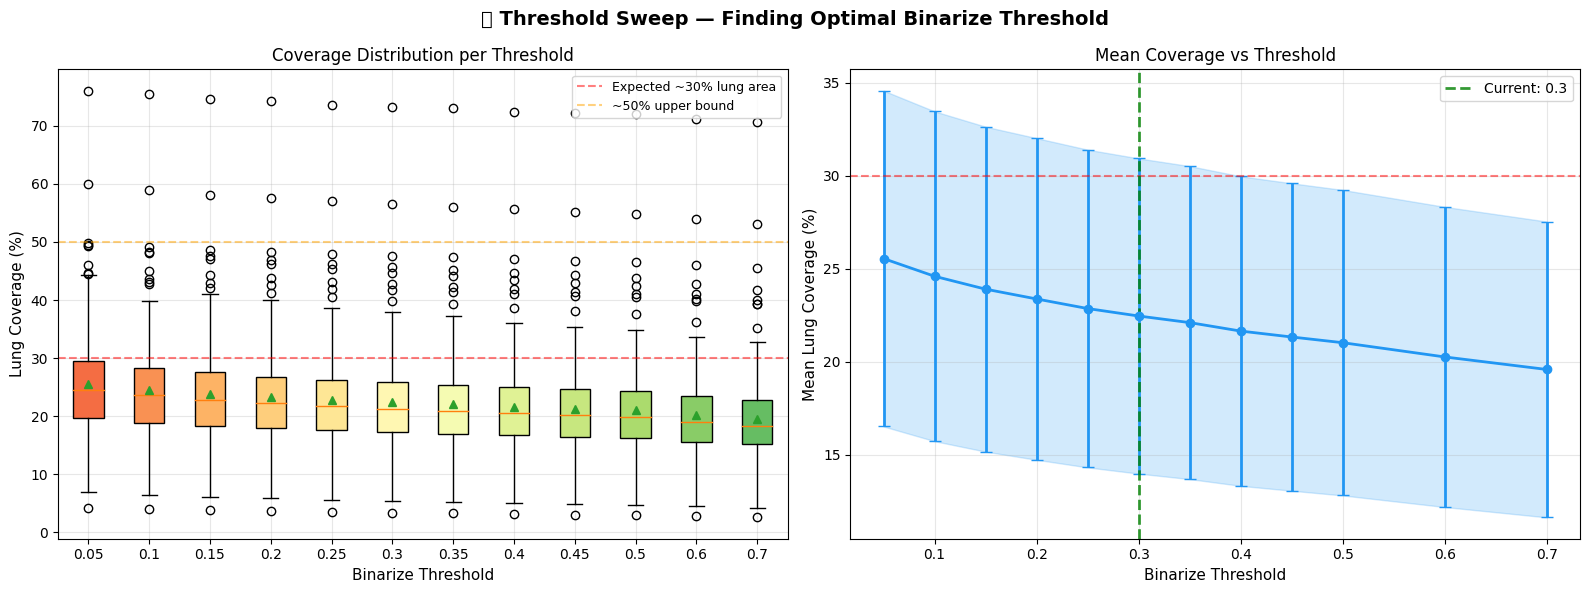


💡 Recommended threshold: 0.05 (mean coverage=25.6%)
   Current threshold:    0.3


In [6]:
# ============================================
# 📈 Step 6: Fine-Grained Threshold Sweep
# ============================================
# Sweep the binarize threshold to find the sweet spot

thresholds_to_test = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]

# Use a larger sample for statistics
np.random.seed(123)
sweep_indices = np.random.choice(len(df), size=200, replace=False)

results = {t: [] for t in thresholds_to_test}

for i in tqdm(sweep_indices, desc="Sweeping thresholds"):
    img = load_and_preprocess(df.iloc[i]['Image Path'], cfg.img_size)
    for t in thresholds_to_test:
        test_cfg = SegConfig()
        test_cfg.mask_binarize_threshold = t
        mask = segment_lungs(img, config=test_cfg)
        results[t].append(mask.mean() * 100)

# Plot coverage distribution per threshold
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
data_for_box = [results[t] for t in thresholds_to_test]
bp = axes[0].boxplot(data_for_box, labels=[f"{t}" for t in thresholds_to_test],
                     patch_artist=True, showmeans=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(thresholds_to_test)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_xlabel('Binarize Threshold', fontsize=11)
axes[0].set_ylabel('Lung Coverage (%)', fontsize=11)
axes[0].set_title('Coverage Distribution per Threshold', fontsize=12)
axes[0].axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Expected ~30% lung area')
axes[0].axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='~50% upper bound')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Mean + std plot
means = [np.mean(results[t]) for t in thresholds_to_test]
stds = [np.std(results[t]) for t in thresholds_to_test]
axes[1].errorbar(thresholds_to_test, means, yerr=stds, fmt='o-', capsize=4,
                 color='#2196F3', linewidth=2, markersize=6)
axes[1].fill_between(thresholds_to_test,
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.2, color='#2196F3')
axes[1].set_xlabel('Binarize Threshold', fontsize=11)
axes[1].set_ylabel('Mean Lung Coverage (%)', fontsize=11)
axes[1].set_title('Mean Coverage vs Threshold', fontsize=12)
axes[1].axhline(y=30, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Highlight the current config's threshold
axes[1].axvline(x=cfg.mask_binarize_threshold, color='green', linestyle='--',
                alpha=0.8, linewidth=2, label=f'Current: {cfg.mask_binarize_threshold}')
axes[1].legend(fontsize=10)

plt.suptitle("📈 Threshold Sweep — Finding Optimal Binarize Threshold",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MASK_OUTPUT_DIR, 'threshold_sweep.png'), dpi=150, bbox_inches='tight')
plt.show()

# Recommend best threshold
ideal_coverage = 35  # typical lung area in chest X-ray
best_t = min(thresholds_to_test, key=lambda t: abs(np.mean(results[t]) - ideal_coverage))
print(f"\n💡 Recommended threshold: {best_t} (mean coverage={np.mean(results[best_t]):.1f}%)")
print(f"   Current threshold:    {cfg.mask_binarize_threshold}")

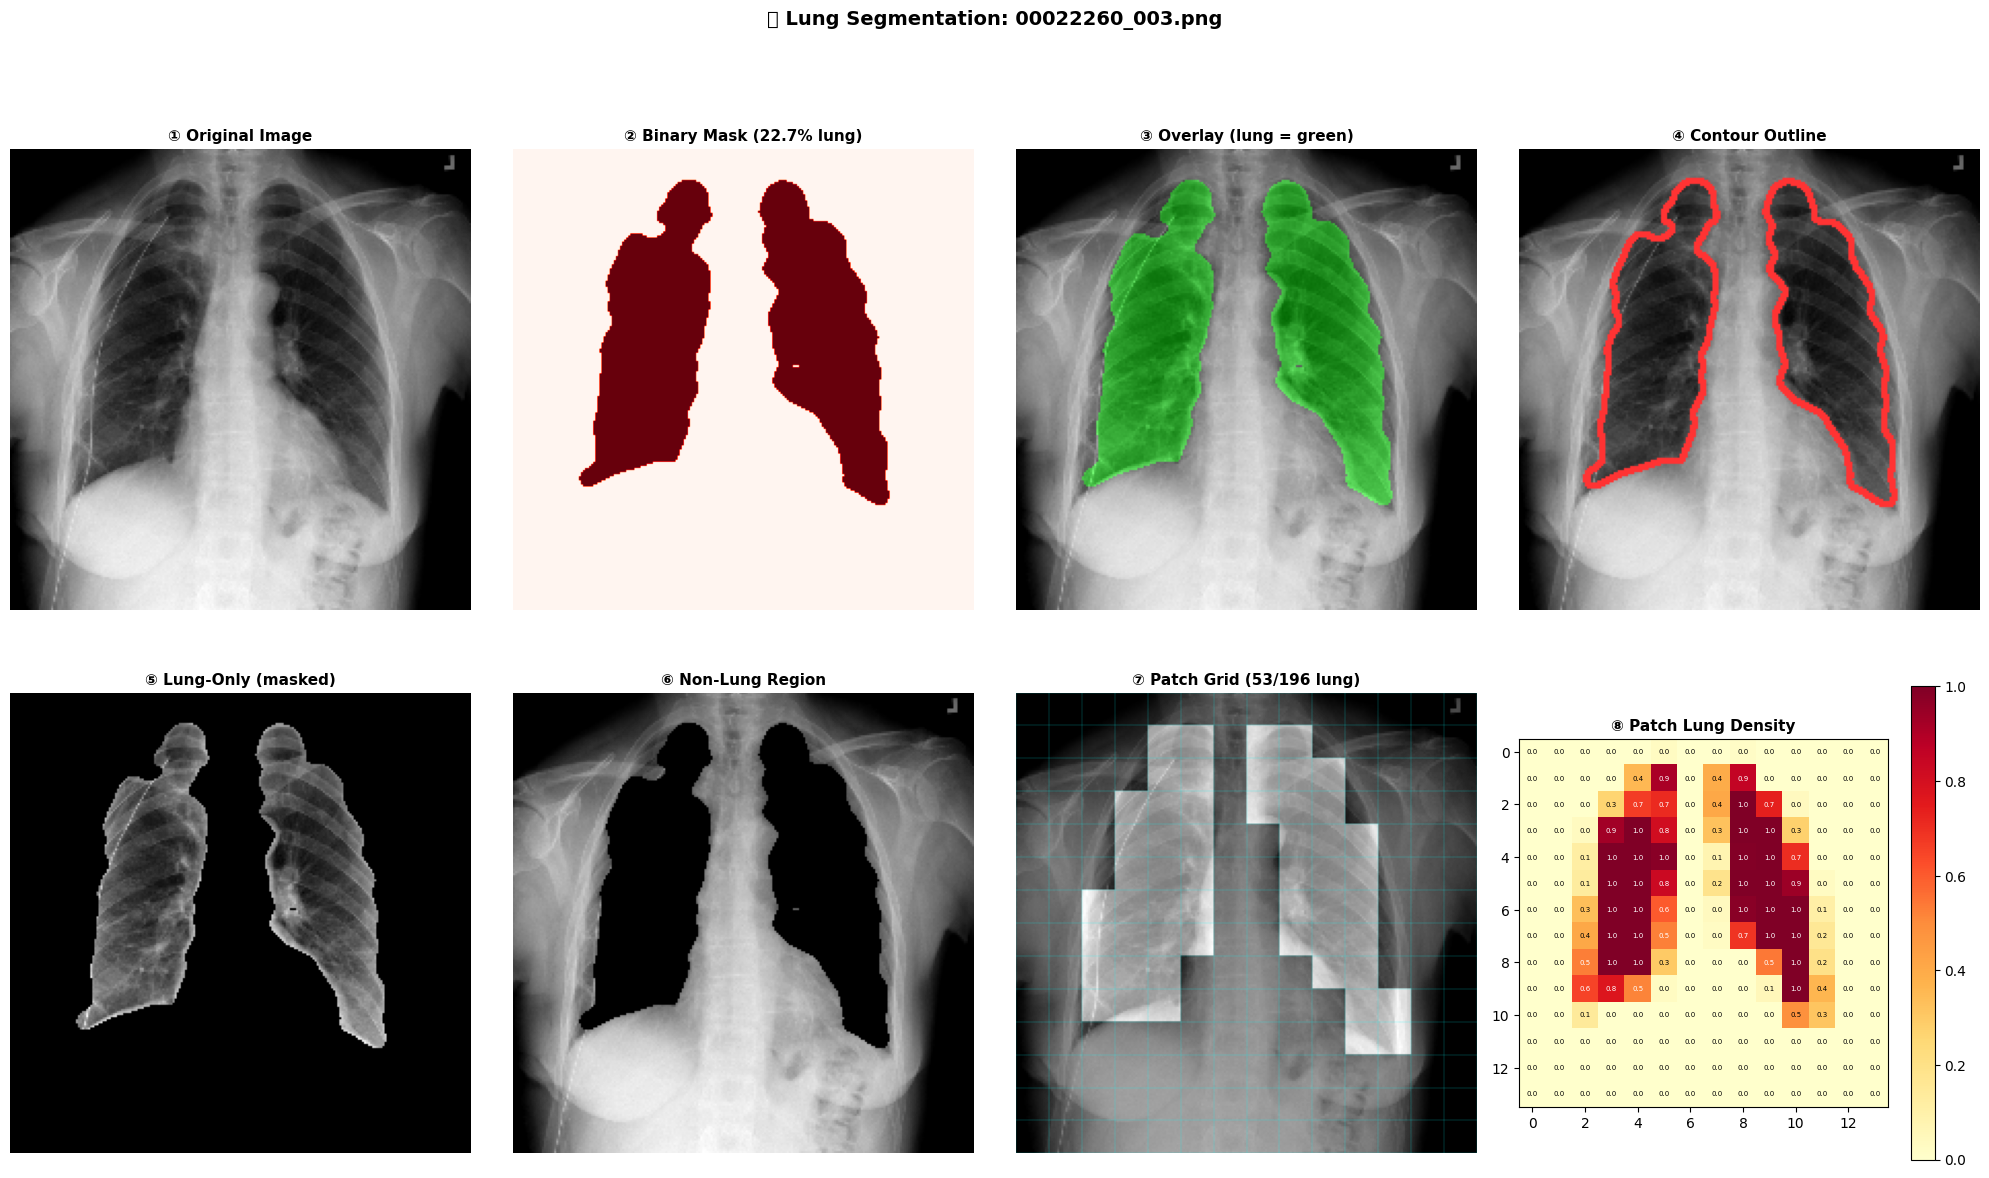

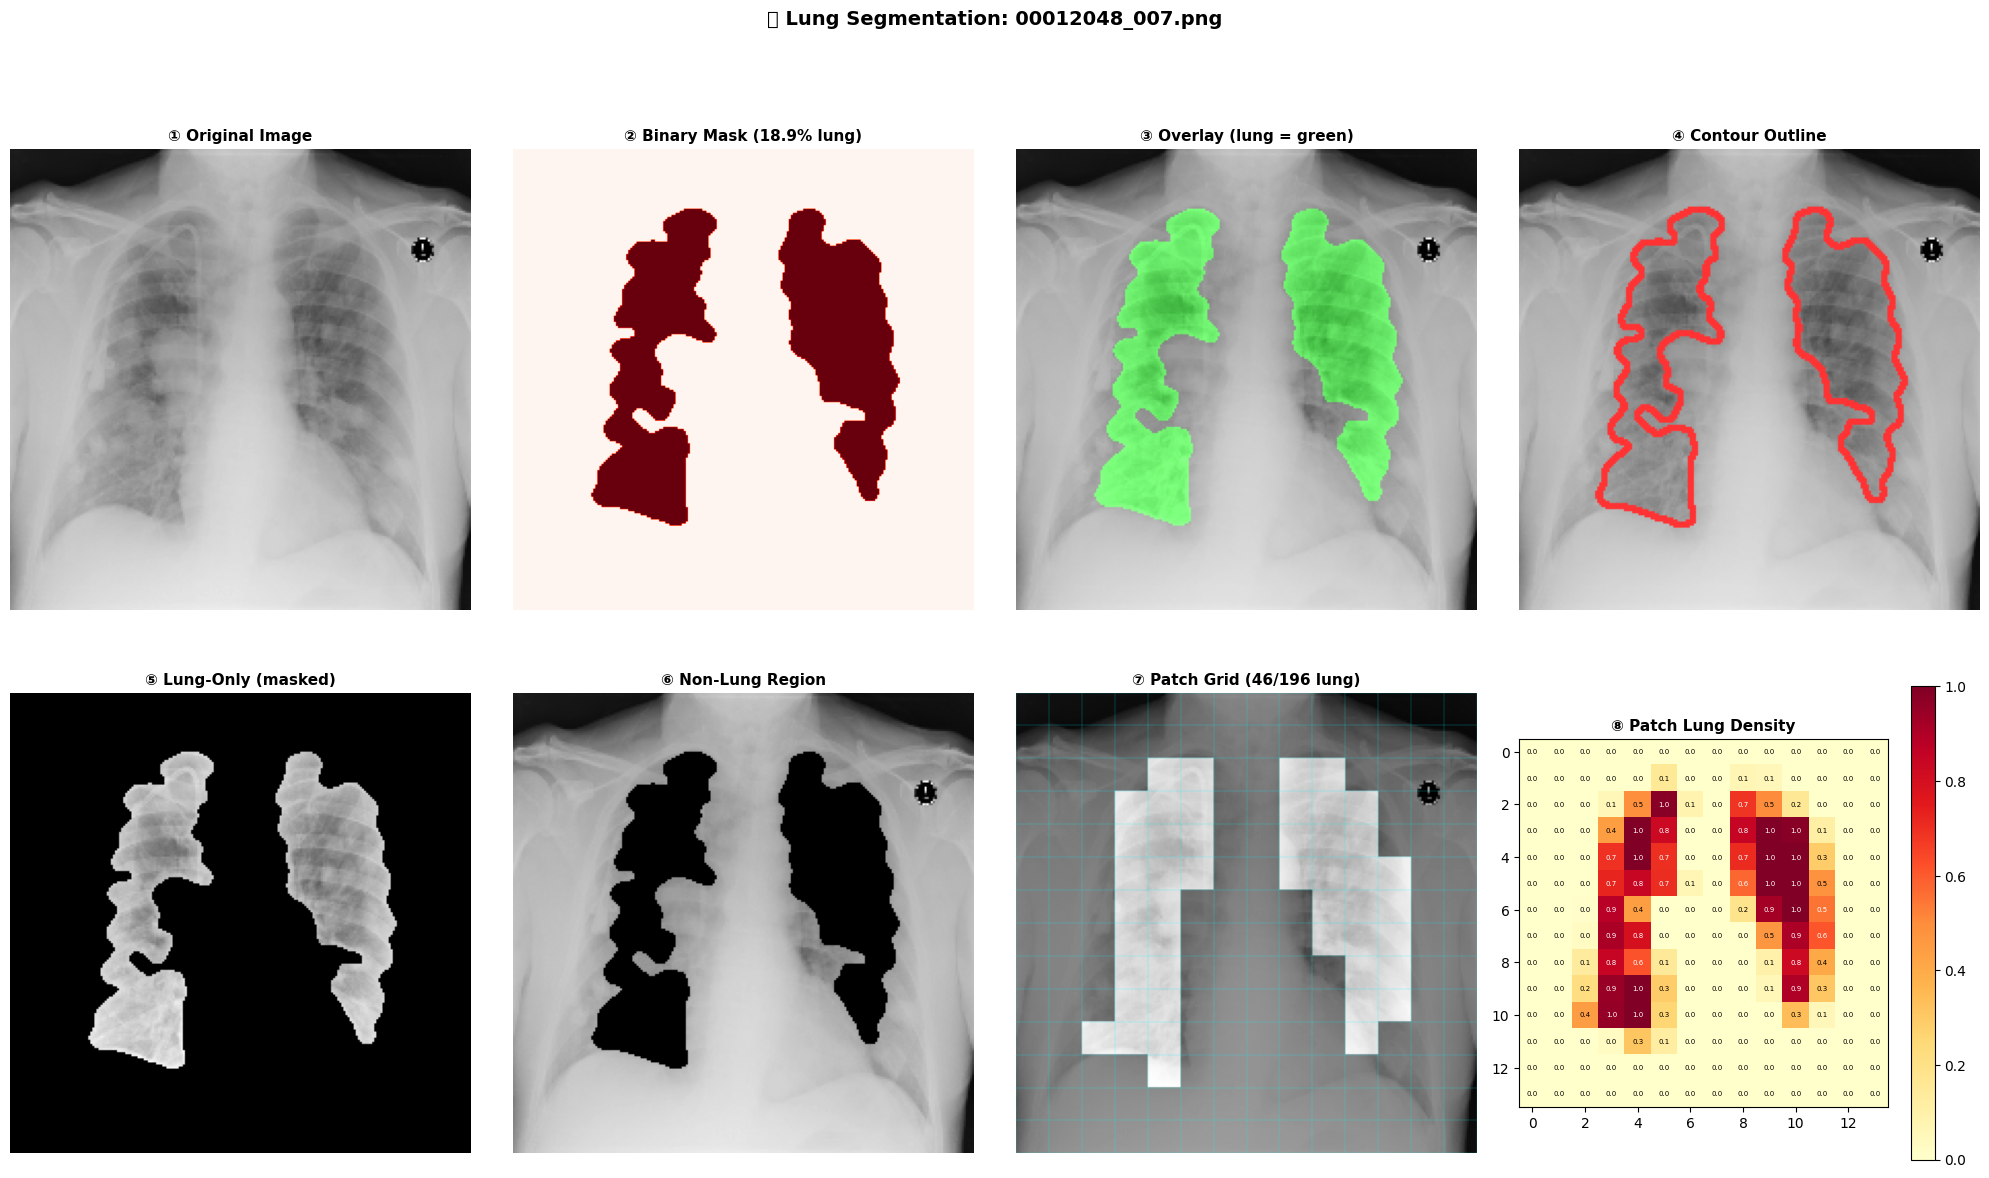

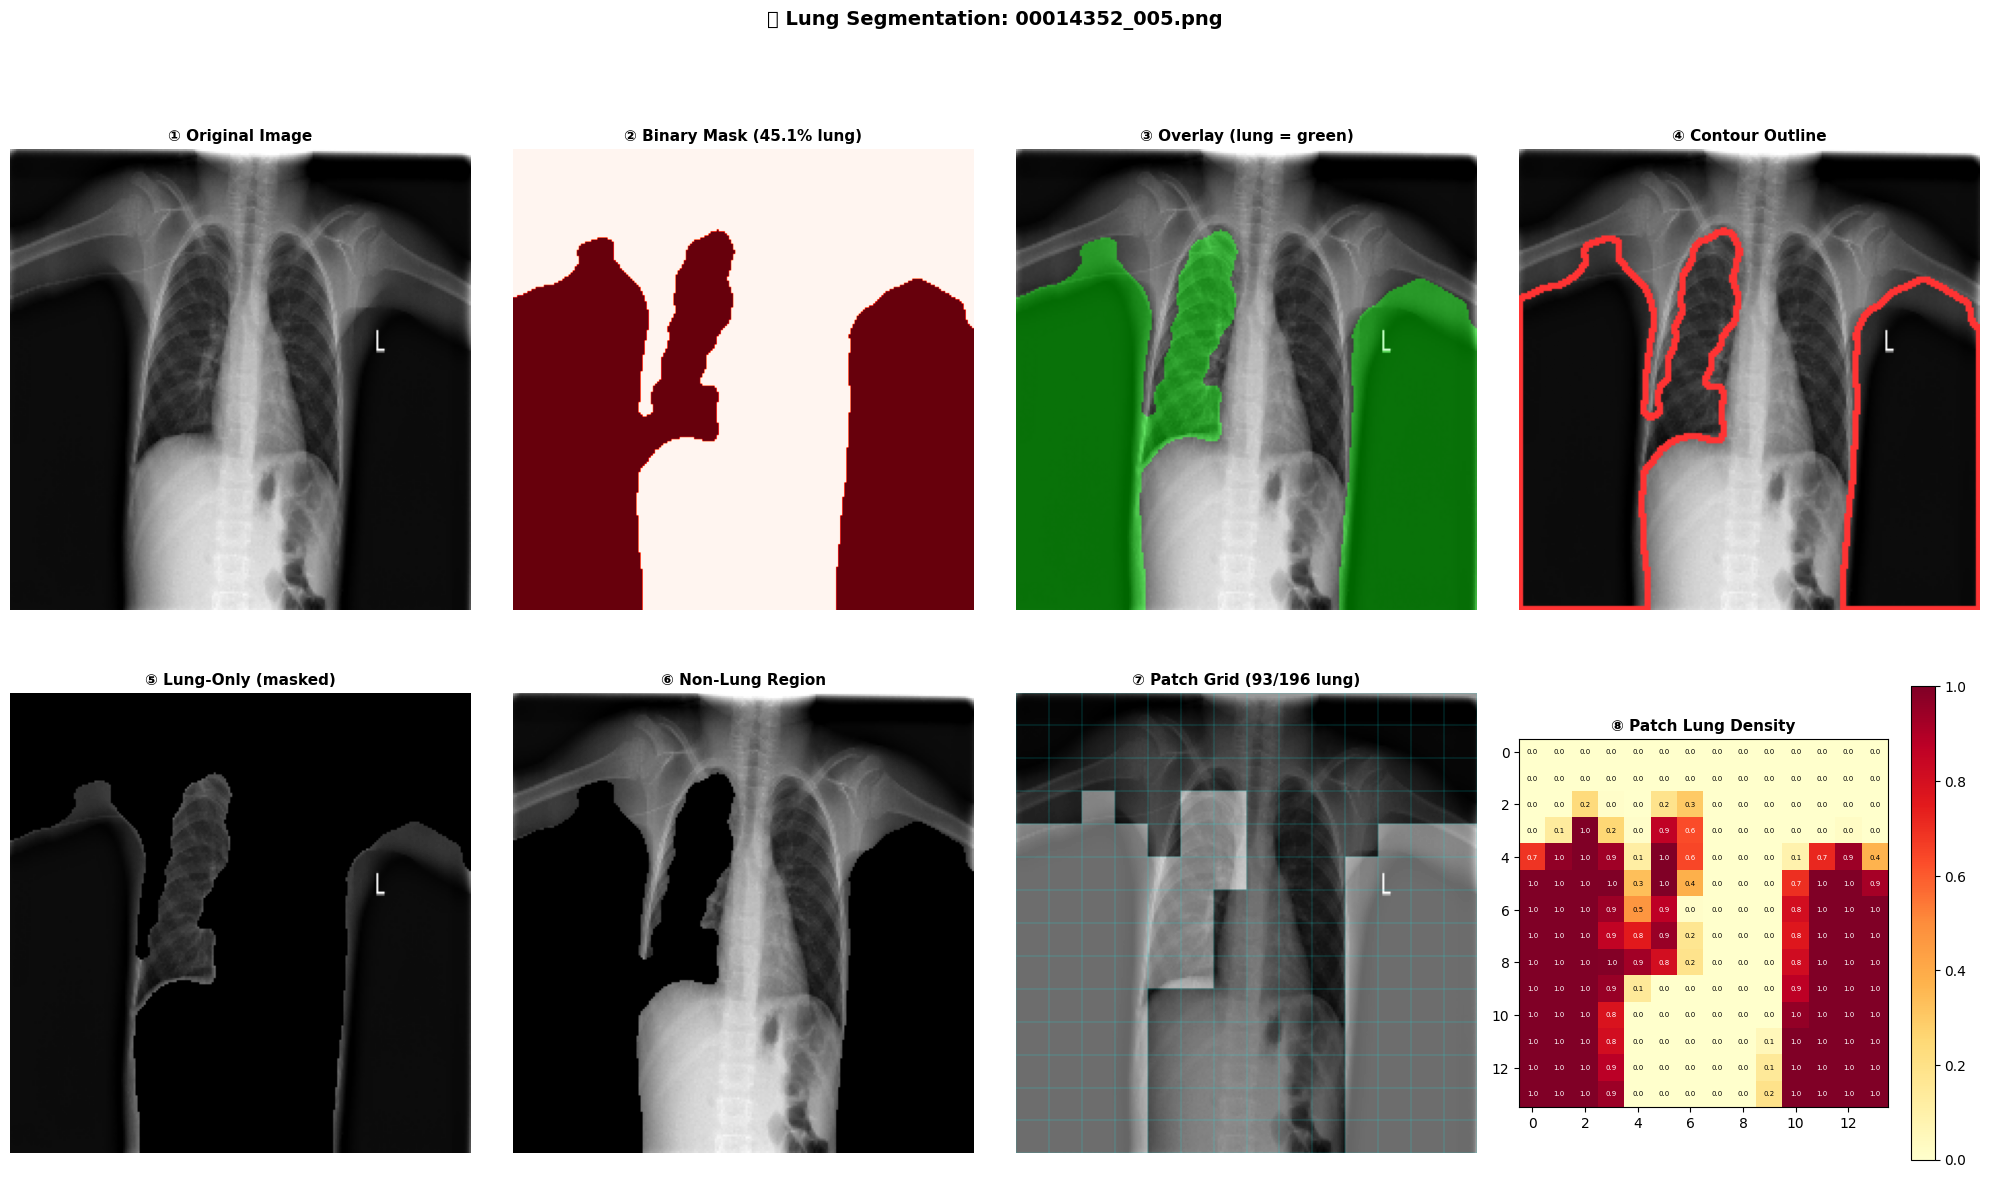

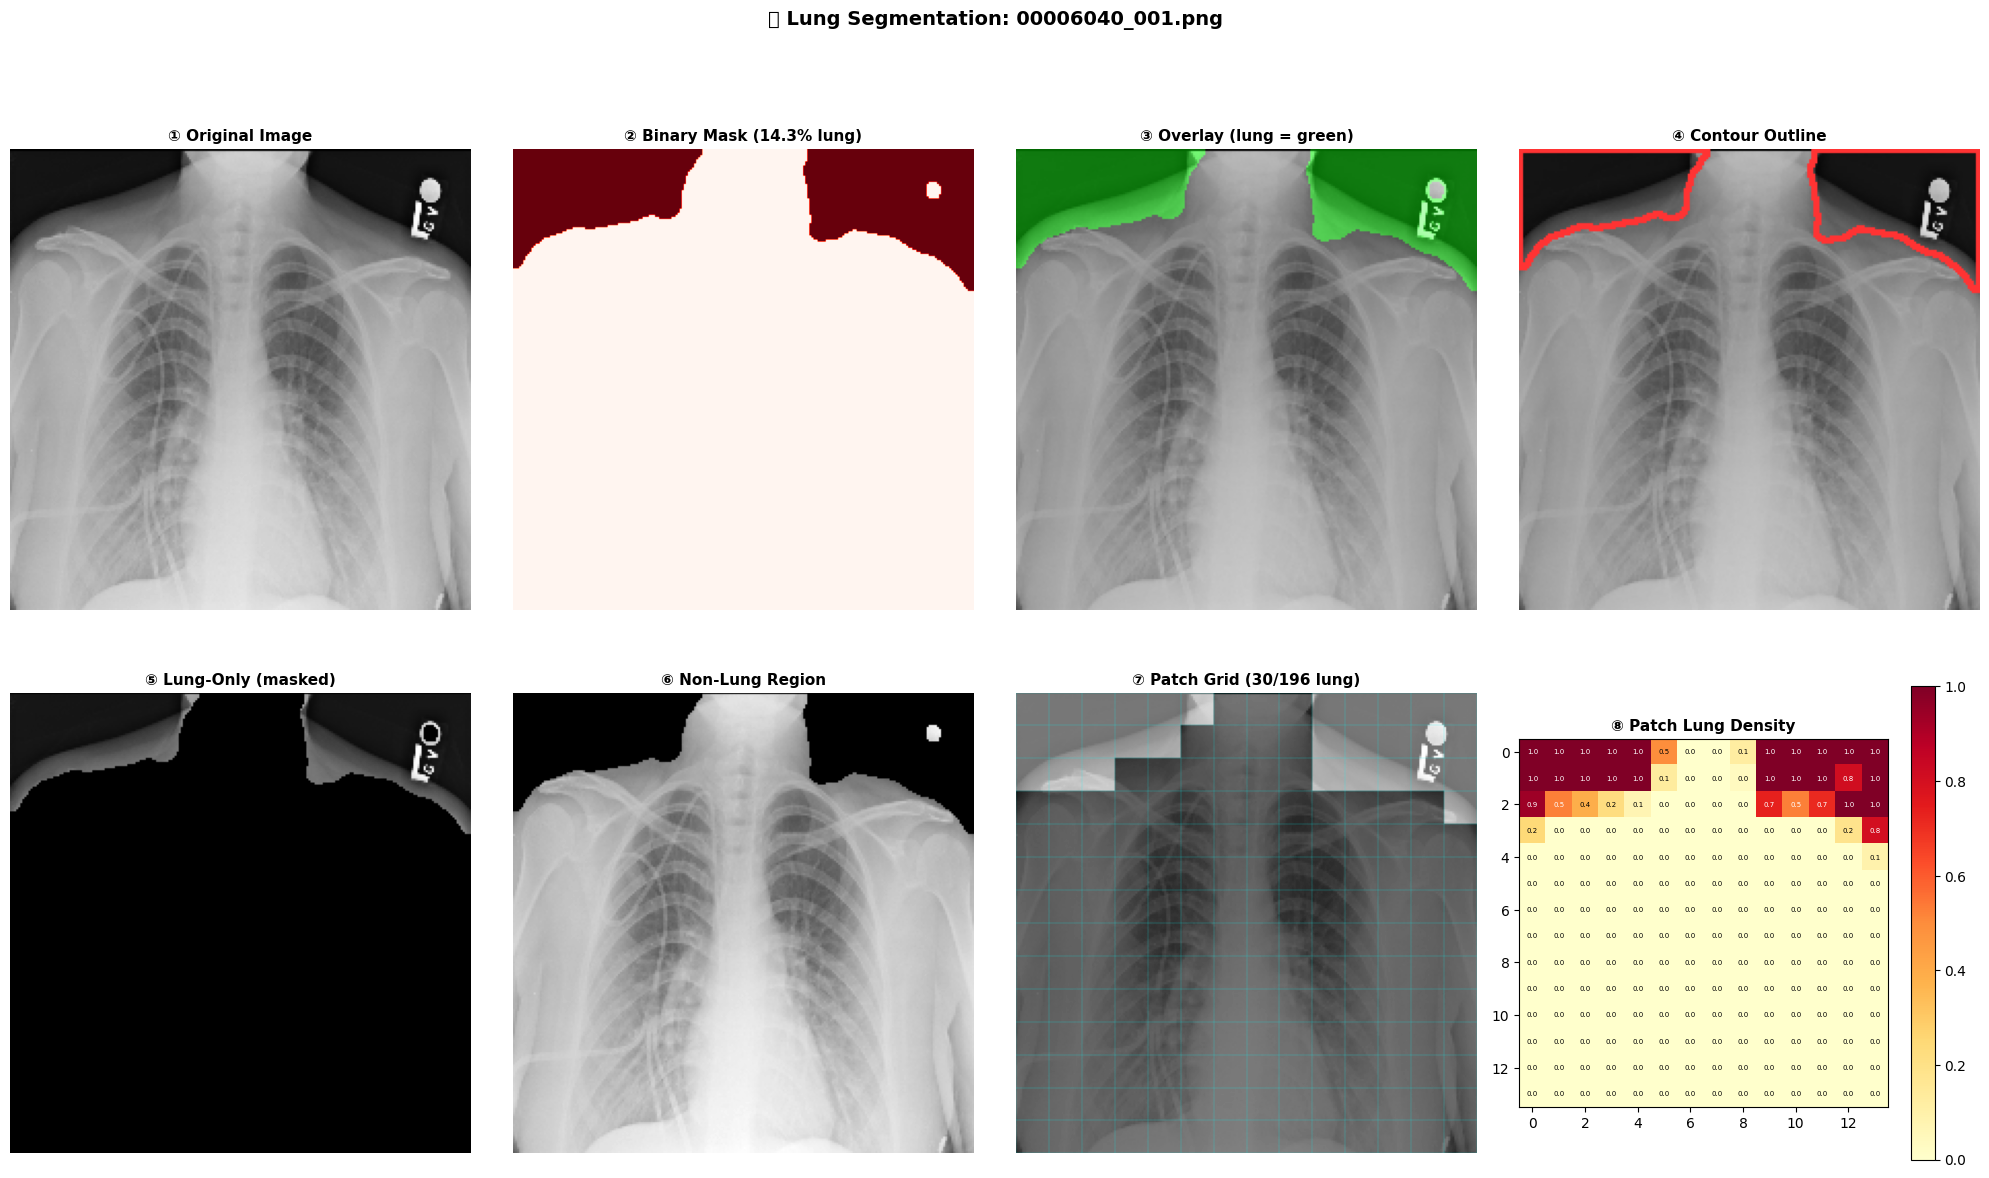


✅ Multi-perspective visualizations saved


In [7]:
# ============================================
# 🎨 Step 7: Multi-Perspective Segmentation Visualization
# ============================================

def visualize_segmentation_multiperspective(img_path, img_name, config=None):
    """
    Show 6 different views of the segmentation for a single image.
    """
    if config is None:
        config = cfg

    img = load_and_preprocess(img_path, config.img_size)
    mask = segment_lungs(img, config=config)
    patch_mask = lung_mask_to_patch_mask(mask, config.patch_size, config.img_size, config.patch_lung_threshold)

    h_patches = config.img_size // config.patch_size
    w_patches = config.img_size // config.patch_size

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1, 1])

    # ── 1. Original Image ──
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img, cmap='gray')
    ax1.set_title("① Original Image", fontsize=11, fontweight='bold')
    ax1.axis('off')

    # ── 2. Binary Mask ──
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(mask, cmap='Reds', vmin=0, vmax=1)
    ax2.set_title(f"② Binary Mask ({mask.mean()*100:.1f}% lung)", fontsize=11, fontweight='bold')
    ax2.axis('off')

    # ── 3. Green Overlay ──
    ax3 = fig.add_subplot(gs[0, 2])
    overlay = np.stack([img, img, img], axis=-1)
    green_overlay = overlay.copy()
    green_overlay[:, :, 1] = np.clip(overlay[:, :, 1] + mask * 0.4, 0, 1)
    green_overlay[:, :, 0] = overlay[:, :, 0] * (1 - mask * 0.2)
    green_overlay[:, :, 2] = overlay[:, :, 2] * (1 - mask * 0.2)
    ax3.imshow(green_overlay)
    ax3.set_title("③ Overlay (lung = green)", fontsize=11, fontweight='bold')
    ax3.axis('off')

    # ── 4. Contour Outline ──
    ax4 = fig.add_subplot(gs[0, 3])
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.stack([img, img, img], axis=-1).copy()
    # Draw contours in red
    for c in contours:
        for point in c:
            x, y = point[0]
            cv2.circle(contour_img, (x, y), 1, (1.0, 0.2, 0.2), -1)
    # Draw thicker contour
    contour_vis = np.zeros_like(mask_uint8)
    cv2.drawContours(contour_vis, contours, -1, 255, 2)
    contour_img[contour_vis > 0] = [1.0, 0.2, 0.2]
    ax4.imshow(contour_img)
    ax4.set_title("④ Contour Outline", fontsize=11, fontweight='bold')
    ax4.axis('off')

    # ── 5. Masked-Out Image (lung only) ──
    ax5 = fig.add_subplot(gs[1, 0])
    masked_img = img * mask
    ax5.imshow(masked_img, cmap='gray')
    ax5.set_title("⑤ Lung-Only (masked)", fontsize=11, fontweight='bold')
    ax5.axis('off')

    # ── 6. Inverted: Non-lung region ──
    ax6 = fig.add_subplot(gs[1, 1])
    non_lung = img * (1 - mask)
    ax6.imshow(non_lung, cmap='gray')
    ax6.set_title("⑥ Non-Lung Region", fontsize=11, fontweight='bold')
    ax6.axis('off')

    # ── 7. Patch-Level Grid ──
    ax7 = fig.add_subplot(gs[1, 2])
    patch_grid = patch_mask.reshape(h_patches, w_patches)
    # Upsample for display
    patch_vis = np.kron(patch_grid, np.ones((config.patch_size, config.patch_size)))
    blended = img * 0.6 + patch_vis * 0.4
    ax7.imshow(blended, cmap='gray')
    # Draw grid lines
    for i in range(h_patches + 1):
        ax7.axhline(i * config.patch_size - 0.5, color='cyan', linewidth=0.3, alpha=0.5)
    for j in range(w_patches + 1):
        ax7.axvline(j * config.patch_size - 0.5, color='cyan', linewidth=0.3, alpha=0.5)
    n_lung_patches = int(patch_mask.sum())
    ax7.set_title(f"⑦ Patch Grid ({n_lung_patches}/{len(patch_mask)} lung)", fontsize=11, fontweight='bold')
    ax7.axis('off')

    # ── 8. Patch-level heatmap ──
    ax8 = fig.add_subplot(gs[1, 3])
    # Compute per-patch mean intensity
    reshaped = mask.reshape(h_patches, config.patch_size, w_patches, config.patch_size)
    patch_means = reshaped.transpose(0, 2, 1, 3).reshape(h_patches * w_patches, -1).mean(axis=1)
    heatmap = patch_means.reshape(h_patches, w_patches)
    im = ax8.imshow(heatmap, cmap='YlOrRd', vmin=0, vmax=1, interpolation='nearest')
    ax8.set_title("⑧ Patch Lung Density", fontsize=11, fontweight='bold')
    for i in range(h_patches):
        for j in range(w_patches):
            val = heatmap[i, j]
            color = 'white' if val > 0.5 else 'black'
            ax8.text(j, i, f"{val:.1f}", ha='center', va='center', fontsize=5, color=color)
    plt.colorbar(im, ax=ax8, shrink=0.8)

    fig.suptitle(f"🫁 Lung Segmentation: {img_name}", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Show multi-perspective views for 4 sample images
for i in range(min(4, len(sample_paths))):
    fig = visualize_segmentation_multiperspective(sample_paths[i], sample_names[i])
    fig.savefig(os.path.join(MASK_OUTPUT_DIR, f'viz_{sample_names[i].replace(".png", "")}.png'),
                dpi=150, bbox_inches='tight')
    plt.show()

print("\n✅ Multi-perspective visualizations saved")

Computing statistics: 100%|██████████| 2000/2000 [00:45<00:00, 43.55it/s]


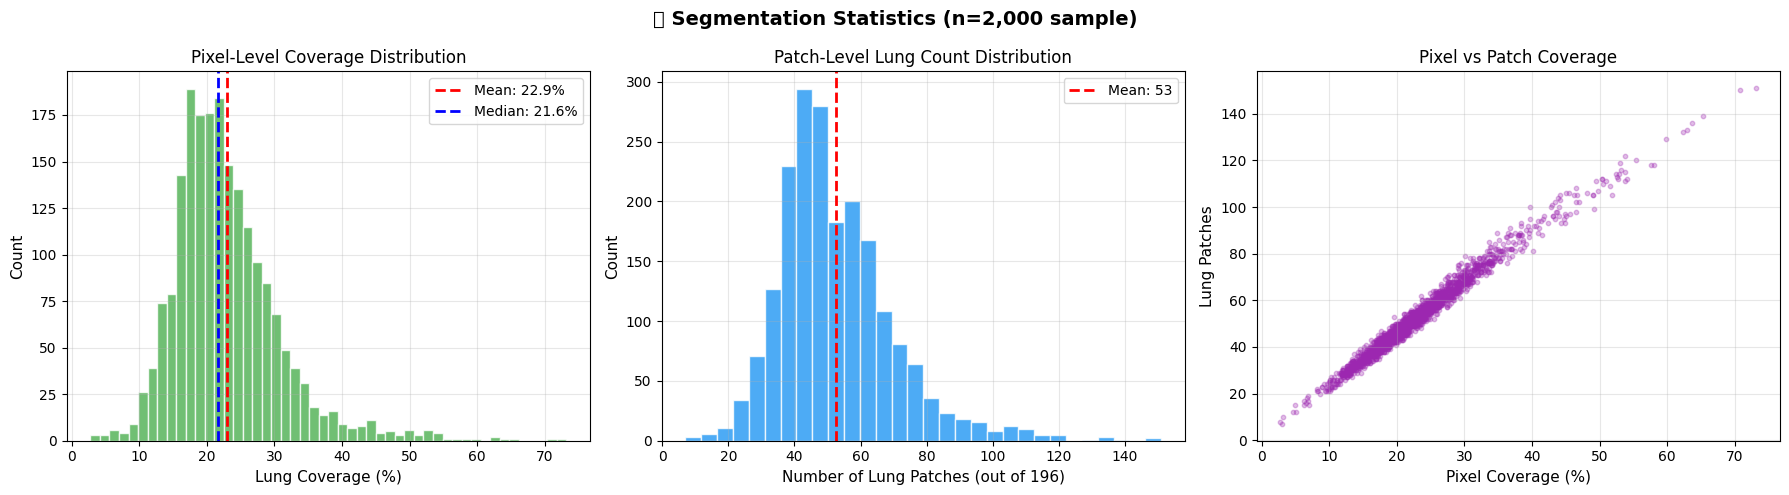


📊 Summary:
   Pixel coverage: 22.9% ± 8.0%
   Lung patches:   53 ± 18 (out of 196)
   Zero-coverage images: 0


In [8]:
# ============================================
# 📊 Step 8: Dataset-Wide Segmentation Statistics
# ============================================

np.random.seed(99)
stat_indices = np.random.choice(len(df), size=min(2000, len(df)), replace=False)

coverages = []
n_lung_patches_list = []
total_patches = (cfg.img_size // cfg.patch_size) ** 2

for i in tqdm(stat_indices, desc="Computing statistics"):
    img = load_and_preprocess(df.iloc[i]['Image Path'], cfg.img_size)
    mask = segment_lungs(img, config=cfg)
    patch_mask = lung_mask_to_patch_mask(mask, cfg.patch_size, cfg.img_size, cfg.patch_lung_threshold)
    coverages.append(mask.mean() * 100)
    n_lung_patches_list.append(patch_mask.sum())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Coverage histogram
axes[0].hist(coverages, bins=50, color='#4CAF50', alpha=0.8, edgecolor='white')
axes[0].axvline(np.mean(coverages), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(coverages):.1f}%')
axes[0].axvline(np.median(coverages), color='blue', linestyle='--', linewidth=2,
                label=f'Median: {np.median(coverages):.1f}%')
axes[0].set_xlabel('Lung Coverage (%)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Pixel-Level Coverage Distribution', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Lung patches histogram
axes[1].hist(n_lung_patches_list, bins=30, color='#2196F3', alpha=0.8, edgecolor='white')
axes[1].axvline(np.mean(n_lung_patches_list), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(n_lung_patches_list):.0f}')
axes[1].set_xlabel(f'Number of Lung Patches (out of {total_patches})', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Patch-Level Lung Count Distribution', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Scatter: coverage vs lung patches
axes[2].scatter(coverages, n_lung_patches_list, alpha=0.3, s=10, color='#9C27B0')
axes[2].set_xlabel('Pixel Coverage (%)', fontsize=11)
axes[2].set_ylabel('Lung Patches', fontsize=11)
axes[2].set_title('Pixel vs Patch Coverage', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.suptitle(f"📊 Segmentation Statistics (n={len(stat_indices):,} sample)",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MASK_OUTPUT_DIR, 'segmentation_statistics.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Summary:")
print(f"   Pixel coverage: {np.mean(coverages):.1f}% ± {np.std(coverages):.1f}%")
print(f"   Lung patches:   {np.mean(n_lung_patches_list):.0f} ± {np.std(n_lung_patches_list):.0f} (out of {total_patches})")
print(f"   Zero-coverage images: {sum(1 for c in coverages if c < 1)}")

⚠️ Low coverage (<10%): 28 images
⚠️ High coverage (>80%): 0 images


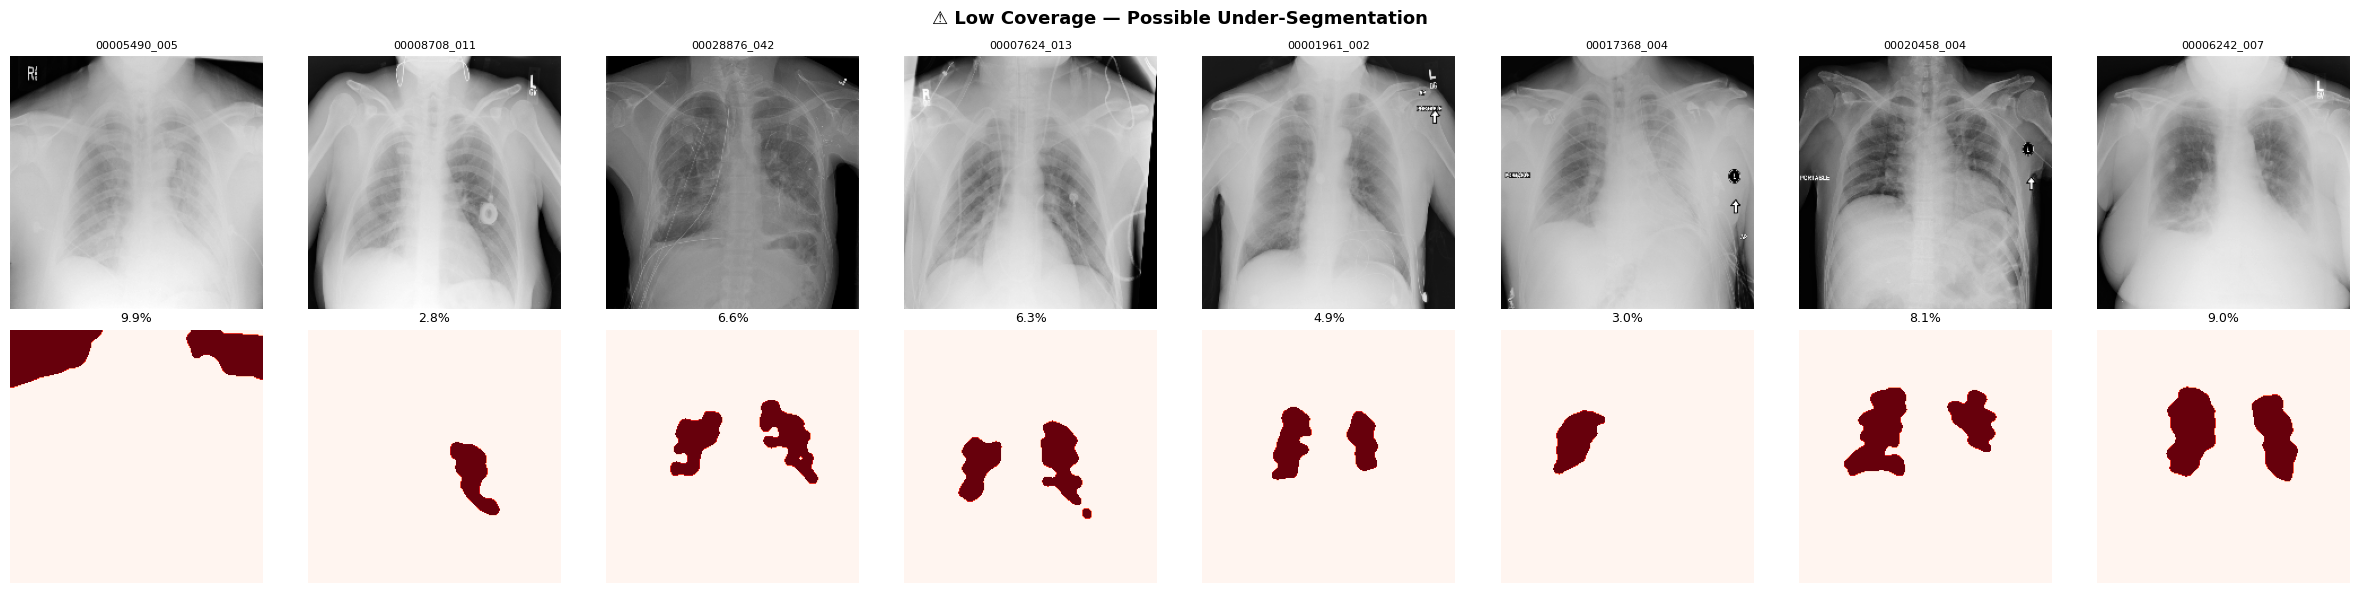

  No High Coverage — Possible Over-Segmentation cases found!


In [9]:
# ============================================
# ⚠️ Step 9: Identify Edge Cases & Failures
# ============================================
# Find images with very low or very high coverage (potential failures)

LOW_THRESHOLD = 10   # % coverage — likely failed segmentation
HIGH_THRESHOLD = 80  # % coverage — likely over-segmented

low_coverage_idx = [stat_indices[i] for i, c in enumerate(coverages) if c < LOW_THRESHOLD]
high_coverage_idx = [stat_indices[i] for i, c in enumerate(coverages) if c > HIGH_THRESHOLD]

print(f"⚠️ Low coverage (<{LOW_THRESHOLD}%): {len(low_coverage_idx)} images")
print(f"⚠️ High coverage (>{HIGH_THRESHOLD}%): {len(high_coverage_idx)} images")

# Visualize edge cases
def show_edge_cases(indices, title, max_show=8):
    n = min(len(indices), max_show)
    if n == 0:
        print(f"  No {title} cases found!")
        return
    fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
    if n == 1:
        axes = axes.reshape(2, 1)
    for i in range(n):
        idx = indices[i]
        img = load_and_preprocess(df.iloc[idx]['Image Path'], cfg.img_size)
        mask = segment_lungs(img, config=cfg)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(df.iloc[idx]['Image Index'][:12], fontsize=8)
        axes[0, i].axis('off')
        axes[1, i].imshow(mask, cmap='Reds')
        axes[1, i].set_title(f"{mask.mean()*100:.1f}%", fontsize=9)
        axes[1, i].axis('off')
    plt.suptitle(f"⚠️ {title}", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_edge_cases(low_coverage_idx, "Low Coverage — Possible Under-Segmentation")
show_edge_cases(high_coverage_idx, "High Coverage — Possible Over-Segmentation")

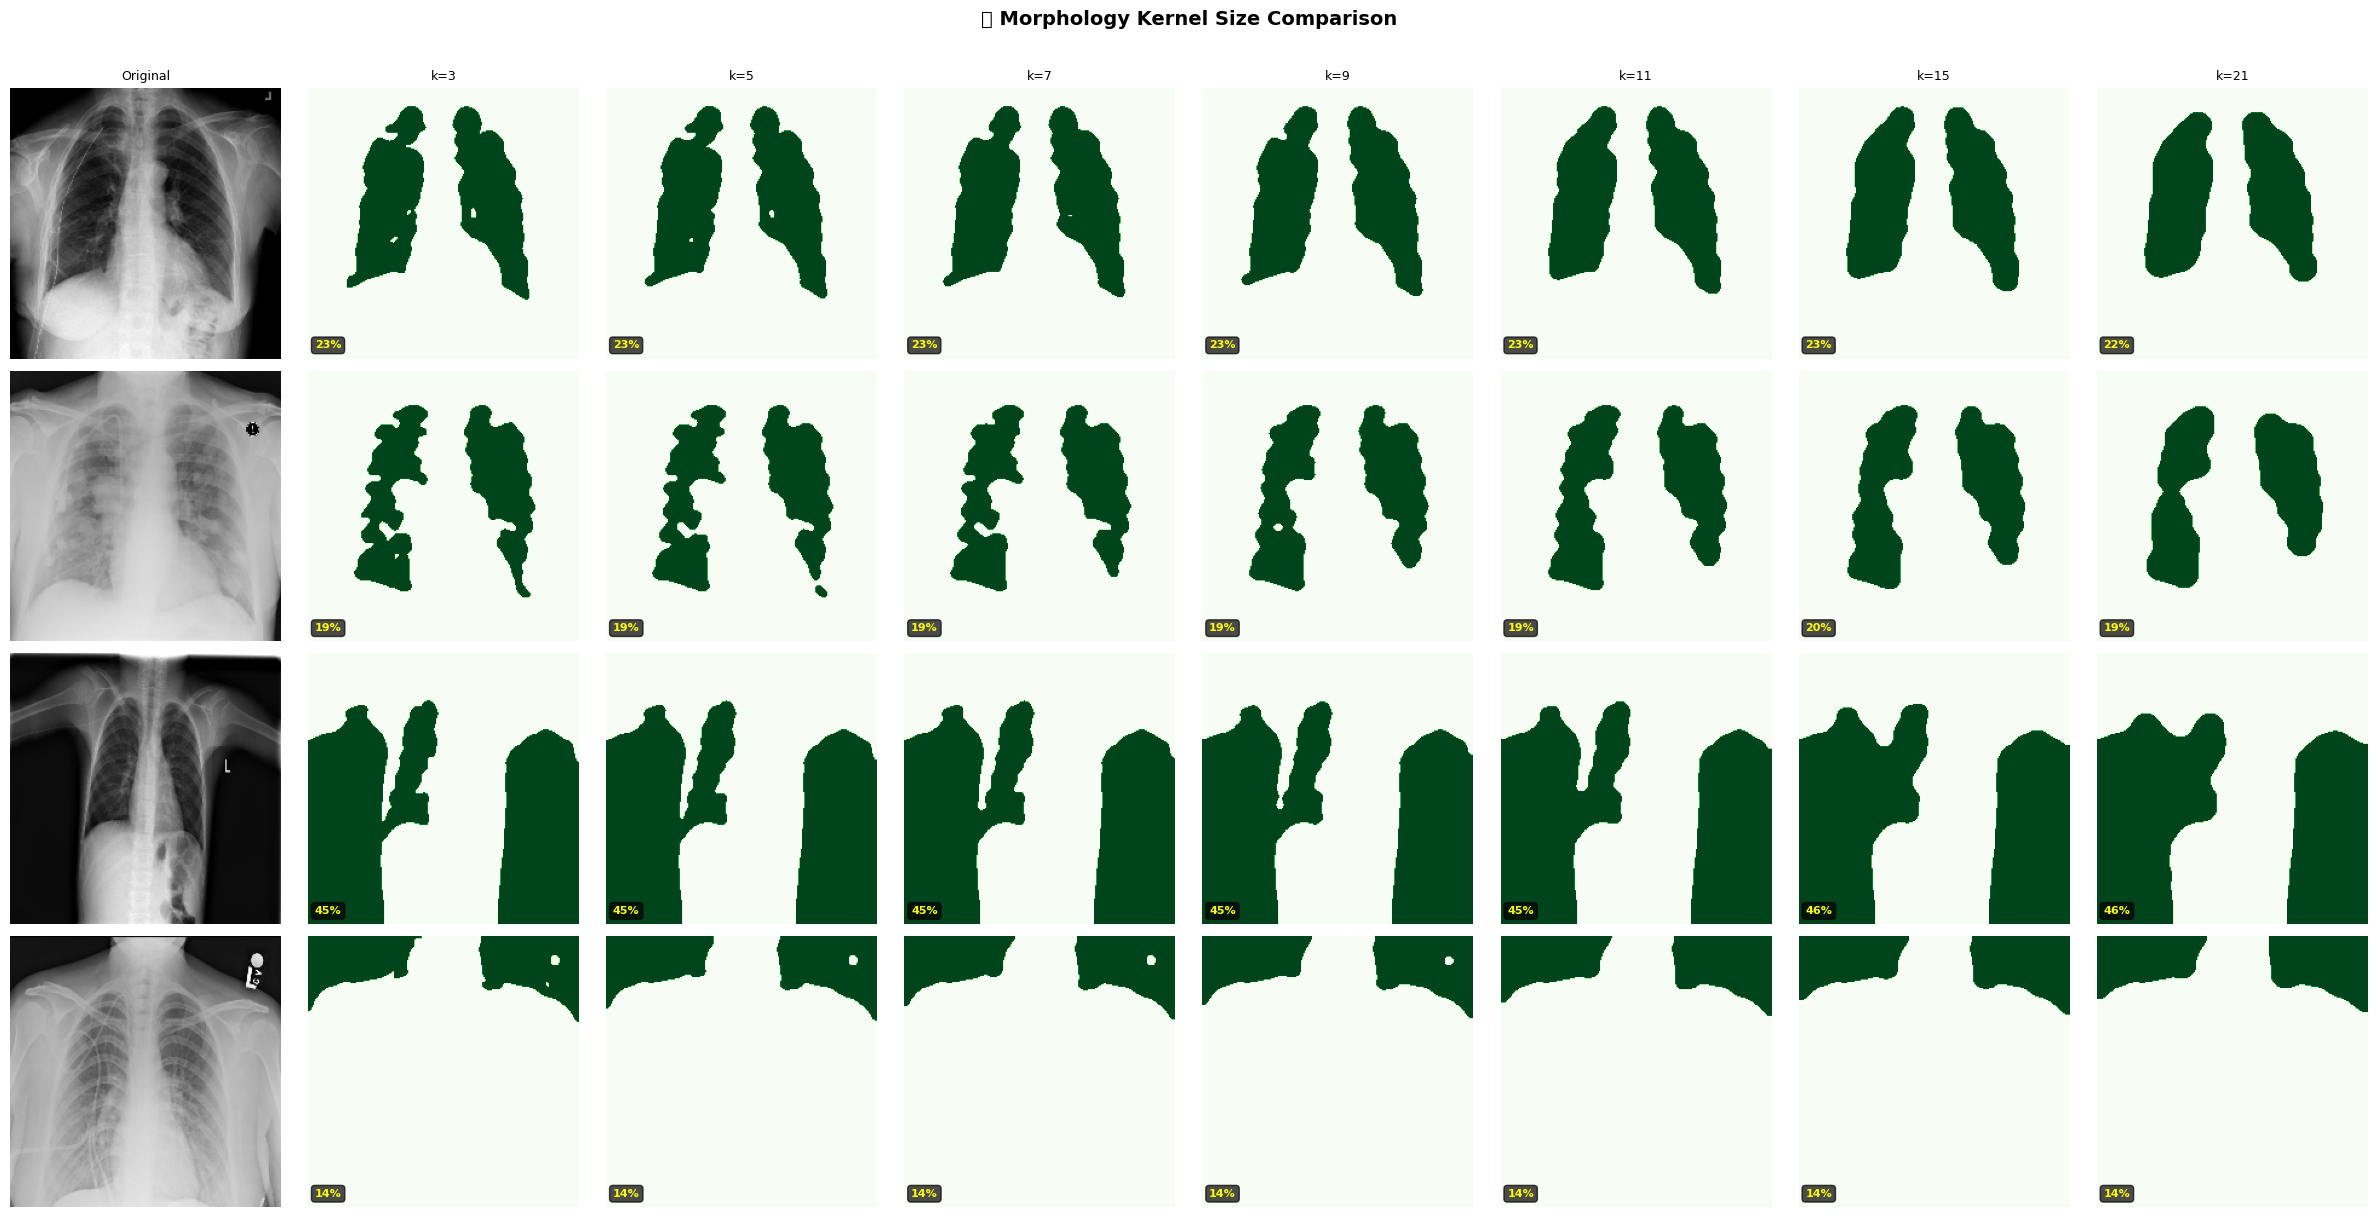

In [10]:
# ============================================
# 🔬 Step 10: Morphology Kernel Size Comparison
# ============================================

kernel_sizes = [3, 5, 7, 9, 11, 15, 21]
n_show = min(4, len(sample_paths))

fig, axes = plt.subplots(n_show, len(kernel_sizes) + 1, figsize=(3 * (len(kernel_sizes) + 1), 3 * n_show))

for row in range(n_show):
    img = load_and_preprocess(sample_paths[row], cfg.img_size)

    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title("Original" if row == 0 else "", fontsize=9)
    axes[row, 0].set_ylabel(sample_names[row][:12], fontsize=8, rotation=0, labelpad=55, va='center')
    axes[row, 0].axis('off')

    for col, ks in enumerate(kernel_sizes, 1):
        test_cfg = SegConfig()
        test_cfg.morph_kernel_size = ks
        mask = segment_lungs(img, config=test_cfg)
        axes[row, col].imshow(mask, cmap='Greens', vmin=0, vmax=1)
        axes[row, col].set_title(f"k={ks}" if row == 0 else "", fontsize=9)
        axes[row, col].text(5, 215, f"{mask.mean()*100:.0f}%", color='yellow', fontsize=8,
                           fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        axes[row, col].axis('off')

plt.suptitle("🔬 Morphology Kernel Size Comparison", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(MASK_OUTPUT_DIR, 'kernel_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# ============================================
# 💾 Step 11: Batch Pre-Compute & Save All Masks to Disk
# ============================================
#
# ╔════════════════════════════════════════════════════════════╗
# ║  ✏️  EDIT cfg above (Step 3) if you want different       ║
# ║     thresholds based on your exploration above.           ║
# ║     Then re-run this cell to save with new settings.      ║
# ╚════════════════════════════════════════════════════════════╝

print(f"💾 Saving masks to: {MASK_OUTPUT_DIR}")
print(f"   Config: otsu={cfg.use_otsu}, morph_k={cfg.morph_kernel_size}, "
      f"binarize_t={cfg.mask_binarize_threshold}, patch_t={cfg.patch_lung_threshold}")
print(f"   Pixel masks: {cfg.save_pixel_masks} → {PIXEL_MASK_DIR}")
print(f"   Patch masks: {cfg.save_patch_masks} → {PATCH_MASK_DIR}")
print()

failed_images = []
total = len(df)

for i in tqdm(range(total), desc="Pre-computing masks", mininterval=2.0):
    img_name = df.iloc[i]['Image Index']  # e.g. "00000001_000.png"
    img_path = df.iloc[i]['Image Path']
    mask_name = img_name.replace('.png', '')

    try:
        img = load_and_preprocess(img_path, cfg.img_size)
        pixel_mask = segment_lungs(img, config=cfg)

        # Save pixel-level mask
        if cfg.save_pixel_masks:
            if cfg.mask_dtype == np.uint8:
                save_mask = (pixel_mask * 255).astype(np.uint8)
            else:
                save_mask = pixel_mask
            np.save(os.path.join(PIXEL_MASK_DIR, f"{mask_name}.npy"), save_mask)

        # Save patch-level mask
        if cfg.save_patch_masks:
            patch_mask = lung_mask_to_patch_mask(
                pixel_mask, cfg.patch_size, cfg.img_size, cfg.patch_lung_threshold
            )
            np.save(os.path.join(PATCH_MASK_DIR, f"{mask_name}.npy"), patch_mask)

    except Exception as e:
        failed_images.append((img_name, str(e)))

print(f"\n✅ Pre-computation complete!")
print(f"   Total processed: {total - len(failed_images):,} / {total:,}")
if failed_images:
    print(f"   ⚠️ Failed: {len(failed_images)}")
    for name, err in failed_images[:10]:
        print(f"      {name}: {err}")

# Save config for reproducibility
import json
config_dict = {k: v for k, v in vars(cfg).items()
               if not k.startswith('_') and not callable(v)
               and not isinstance(v, type)}
# Convert numpy types to python types
for k, v in config_dict.items():
    if hasattr(v, 'item'):
        config_dict[k] = v.item()
    elif isinstance(v, type):
        config_dict[k] = str(v)
config_dict['mask_dtype'] = 'uint8' if cfg.mask_dtype == np.uint8 else 'float32'

with open(os.path.join(MASK_OUTPUT_DIR, 'segmentation_config.json'), 'w') as f:
    json.dump(config_dict, f, indent=2)
print(f"\n📄 Config saved to: {os.path.join(MASK_OUTPUT_DIR, 'segmentation_config.json')}")

💾 Saving masks to: ./lung_masks
   Config: otsu=True, morph_k=7, binarize_t=0.3, patch_t=0.3
   Pixel masks: True → ./lung_masks/pixel_masks
   Patch masks: True → ./lung_masks/patch_masks



Pre-computing masks: 100%|██████████| 112120/112120 [46:29<00:00, 40.19it/s]


✅ Pre-computation complete!
   Total processed: 112,120 / 112,120

📄 Config saved to: ./lung_masks/segmentation_config.json


🔍 Verifying saved masks...
   Pixel masks: 112,120 files
   Patch masks: 112,120 files


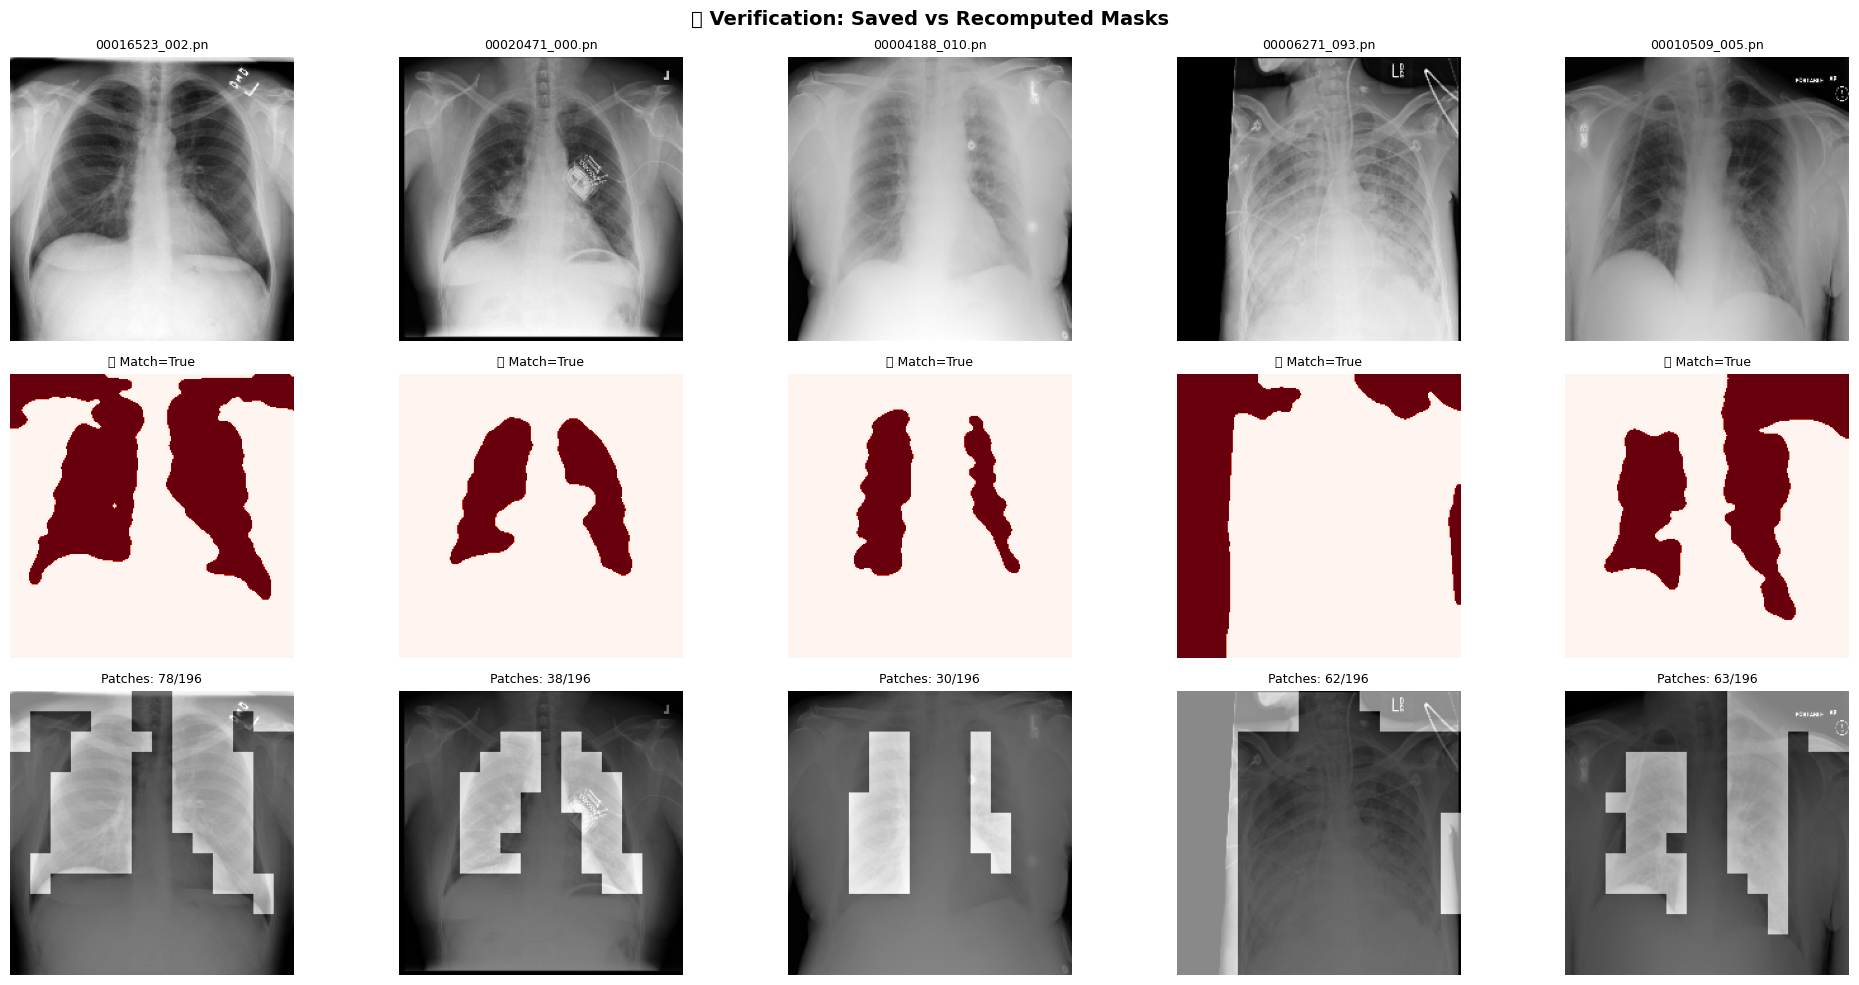


💾 Disk usage:
   Pixel masks: 5.25 GB
   Patch masks: 0.0952 GB
   Total: 5.35 GB


In [12]:
# ============================================
# ✅ Step 12: Verify Saved Masks
# ============================================

print("🔍 Verifying saved masks...")

# Count files
pixel_files = glob.glob(os.path.join(PIXEL_MASK_DIR, '*.npy'))
patch_files = glob.glob(os.path.join(PATCH_MASK_DIR, '*.npy'))

print(f"   Pixel masks: {len(pixel_files):,} files")
print(f"   Patch masks: {len(patch_files):,} files")

# Load a few and verify
n_verify = min(5, len(pixel_files))
verify_indices = np.random.choice(len(df), size=n_verify, replace=False)

fig, axes = plt.subplots(3, n_verify, figsize=(4 * n_verify, 10))

for col, idx in enumerate(verify_indices):
    img_name = df.iloc[idx]['Image Index']
    mask_name = img_name.replace('.png', '')
    img = load_and_preprocess(df.iloc[idx]['Image Path'], cfg.img_size)

    # Load saved masks
    pixel_mask_path = os.path.join(PIXEL_MASK_DIR, f"{mask_name}.npy")
    patch_mask_path = os.path.join(PATCH_MASK_DIR, f"{mask_name}.npy")

    pixel_mask = np.load(pixel_mask_path)
    patch_mask = np.load(patch_mask_path)

    # Convert back if uint8
    if pixel_mask.dtype == np.uint8:
        pixel_mask = pixel_mask.astype(np.float32) / 255.0

    # Recompute to verify
    recomputed = segment_lungs(img, config=cfg)
    match = np.allclose(pixel_mask, recomputed, atol=1e-5)

    # Original
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(img_name[:15], fontsize=9)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_ylabel("Original", fontsize=10, fontweight='bold')

    # Loaded mask
    axes[1, col].imshow(pixel_mask, cmap='Reds', vmin=0, vmax=1)
    axes[1, col].set_title(f"{'✅' if match else '❌'} Match={match}", fontsize=9)
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_ylabel("Saved Mask", fontsize=10, fontweight='bold')

    # Patch mask overlay
    h_p = cfg.img_size // cfg.patch_size
    w_p = cfg.img_size // cfg.patch_size
    patch_vis = np.kron(patch_mask.reshape(h_p, w_p),
                        np.ones((cfg.patch_size, cfg.patch_size)))
    blended = img * 0.5 + patch_vis * 0.5
    axes[2, col].imshow(blended, cmap='gray')
    axes[2, col].set_title(f"Patches: {int(patch_mask.sum())}/{len(patch_mask)}", fontsize=9)
    axes[2, col].axis('off')
    if col == 0:
        axes[2, col].set_ylabel("Patch Mask", fontsize=10, fontweight='bold')

plt.suptitle("✅ Verification: Saved vs Recomputed Masks", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Disk usage
pixel_size = sum(os.path.getsize(f) for f in pixel_files) / (1024**3)
patch_size_gb = sum(os.path.getsize(f) for f in patch_files) / (1024**3)
print(f"\n💾 Disk usage:")
print(f"   Pixel masks: {pixel_size:.2f} GB")
print(f"   Patch masks: {patch_size_gb:.4f} GB")
print(f"   Total: {pixel_size + patch_size_gb:.2f} GB")

In [13]:
# ============================================
# 📋 Step 13: How to Use Pre-Computed Masks in Other Notebooks
# ============================================

print("""
╔══════════════════════════════════════════════════════════════════╗
║  📋 COPY THIS CODE into your option notebooks                  ║
╚══════════════════════════════════════════════════════════════════╝

# ── Option A: Load pixel-level masks ──

MASK_DIR = './lung_masks/pixel_masks'   # adjust path as needed

class MyDataset(Dataset):
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        mask_name = img_name.replace('.png', '')

        # Load pre-computed mask (fast!)
        mask = np.load(os.path.join(MASK_DIR, f'{mask_name}.npy'))
        if mask.dtype == np.uint8:
            mask = mask.astype(np.float32) / 255.0

        # ... rest of your __getitem__ ...


# ── Option B: Load patch-level masks ──

PATCH_MASK_DIR = './lung_masks/patch_masks'

class MySSLDataset(Dataset):
    def __init__(self, df, ...):
        # Pre-load ALL patch masks into memory (they're tiny!)
        self.patch_masks = []
        for img_name in df['Image Index']:
            mask_name = img_name.replace('.png', '')
            pm = np.load(os.path.join(PATCH_MASK_DIR, f'{mask_name}.npy'))
            self.patch_masks.append(pm)

    def __getitem__(self, idx):
        patch_mask = self.patch_masks[idx]
        # ... use directly, no segmentation needed! ...


# ── Option C: Bulk-load all patch masks into a single array ──

import glob
mask_files = sorted(glob.glob(os.path.join(PATCH_MASK_DIR, '*.npy')))
all_masks = np.stack([np.load(f) for f in mask_files])
print(f"Loaded {all_masks.shape[0]} masks, shape: {all_masks.shape}")
""")


╔══════════════════════════════════════════════════════════════════╗
║  📋 COPY THIS CODE into your option notebooks                  ║
╚══════════════════════════════════════════════════════════════════╝

# ── Option A: Load pixel-level masks ──

MASK_DIR = './lung_masks/pixel_masks'   # adjust path as needed

class MyDataset(Dataset):
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        mask_name = img_name.replace('.png', '')

        # Load pre-computed mask (fast!)
        mask = np.load(os.path.join(MASK_DIR, f'{mask_name}.npy'))
        if mask.dtype == np.uint8:
            mask = mask.astype(np.float32) / 255.0

        # ... rest of your __getitem__ ...


# ── Option B: Load patch-level masks ──

PATCH_MASK_DIR = './lung_masks/patch_masks'

class MySSLDataset(Dataset):
    def __init__(self, df, ...):
        # Pre-load ALL patch masks into memory (they're tiny!)
        self.patch_masks = []
        for img_name in df['Image Index']:
  

In [14]:
# ============================================
# 📝 Step 14: Summary
# ============================================

print("\n" + "=" * 60)
print("📝 LUNG SEGMENTATION PRE-COMPUTATION SUMMARY")
print("=" * 60)

print(f"""
Dataset:    NIH Chest X-ray ({len(df):,} images)
Image size: {cfg.img_size}×{cfg.img_size}

Segmentation Config:
  Threshold:     {'Otsu (auto)' if cfg.use_otsu else f'Fixed ({cfg.fixed_threshold})'}
  Morph kernel:  {cfg.morph_kernel_size}×{cfg.morph_kernel_size}
  Binarize:      {cfg.mask_binarize_threshold}
  Patch size:    {cfg.patch_size}
  Patch thresh:  {cfg.patch_lung_threshold}

Output:
  📂 {MASK_OUTPUT_DIR}/
  ├── pixel_masks/     ({len(pixel_files):,} .npy files)
  ├── patch_masks/     ({len(patch_files):,} .npy files)
  ├── segmentation_config.json
  ├── threshold_comparison.png
  ├── threshold_sweep.png
  └── segmentation_statistics.png

Notebooks that can use these masks:
  • option1  (masked contrastive)
  • option4  (segmentation-guided crop)
  • option5  (attention segmentation)
  • option6  (segmentation channel)
  • option7  (anatomy-masked attention)
""")

print("=" * 60)


📝 LUNG SEGMENTATION PRE-COMPUTATION SUMMARY

Dataset:    NIH Chest X-ray (112,120 images)
Image size: 224×224

Segmentation Config:
  Threshold:     Otsu (auto)
  Morph kernel:  7×7
  Binarize:      0.3
  Patch size:    16
  Patch thresh:  0.3

Output:
  📂 ./lung_masks/
  ├── pixel_masks/     (112,120 .npy files)
  ├── patch_masks/     (112,120 .npy files)
  ├── segmentation_config.json
  ├── threshold_comparison.png
  ├── threshold_sweep.png
  └── segmentation_statistics.png

Notebooks that can use these masks:
  • option1  (masked contrastive)
  • option4  (segmentation-guided crop)
  • option5  (attention segmentation)
  • option6  (segmentation channel)
  • option7  (anatomy-masked attention)



In [32]:
ls checkpoints_option7_anatomy_masked_attention_ssl/

In [20]:
rm checkpoints/*

In [26]:
mv checkpoints_option7_anatomy_masked_attention_ssl/ checkpoints_option7_anatomy_masked_attention_ssl.old

In [34]:
ls

Untitled.ipynb
checkpoints/
checkpoints.old/
checkpoints_option7_anatomy_masked_attention_ssl/
checkpoints_option7_anatomy_masked_attention_ssl.old/
crop_diag_109349.png
crop_diag_25942.png
crop_diag_66807.png
crop_diag_71397.png
crop_diag_84011.png
crop_diag_87627.png
datasets/
lung_masks/
option1_mobilenetv2_best.pth
option4_confusion_matrices_per_disease.png
option4_confusion_matrix_macro.png
option4_roc_curve_macro.png
option4_roc_curves_per_disease.png
option4_smart_crop_with_segmentation.png
option4_ssl_curves.png
option4_ssl_pretrained.pth
option4_test_auc_performance.png
option5_region_attention.png
option6_segmentation_channel_best.pth
option6_training_history.png
option7_anatomy_masked_attention_ssl_auc_performance.png
option7_anatomy_masked_attention_ssl_confusion_matrices.png
option7_anatomy_masked_attention_ssl_finetune_curves.png
option7_anatomy_masked_attention_ssl_roc_curves.png
option7_anatomy_masked_attention_ssl_ssl_curves.png
outputs/
